In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('hotel.csv')

hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

model =keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(256, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation ="sigmoid")
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(
optimizer = "Adam",
loss = "binary_crossentropy",
metrics = ["binary_accuracy"],
)


In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - binary_accuracy: 0.7389 - loss: 0.5411 - val_binary_accuracy: 0.7905 - val_loss: 0.4349
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - binary_accuracy: 0.7984 - loss: 0.4290 - val_binary_accuracy: 0.8093 - val_loss: 0.4035
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - binary_accuracy: 0.8052 - loss: 0.4111 - val_binary_accuracy: 0.8161 - val_loss: 0.3950
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - binary_accuracy: 0.8115 - loss: 0.4046 - val_binary_accuracy: 0.8179 - val_loss: 0.3913
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - binary_accuracy: 0.8136 - loss: 0.3981 - val_binary_accuracy: 0.8196 - val_loss: 0.3878
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - binary_accuracy: 0.8162 - loss: 0.3931 - val_binary_accuracy: 0.8209 - val_loss: 0.3856
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - binary_accuracy: 0.8211 - loss: 0.3863 - val_binary_accuracy: 0.8226 - val_loss:

<Axes: title={'center': 'Accuracy'}>

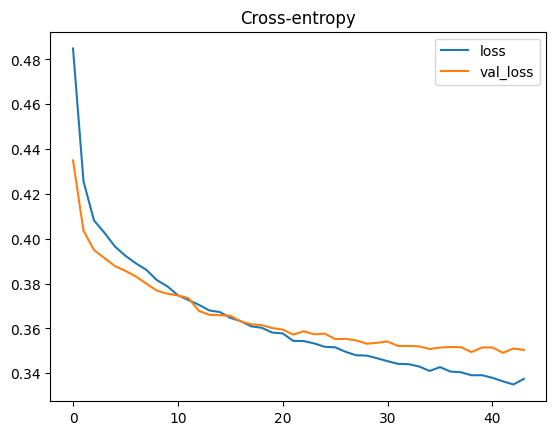

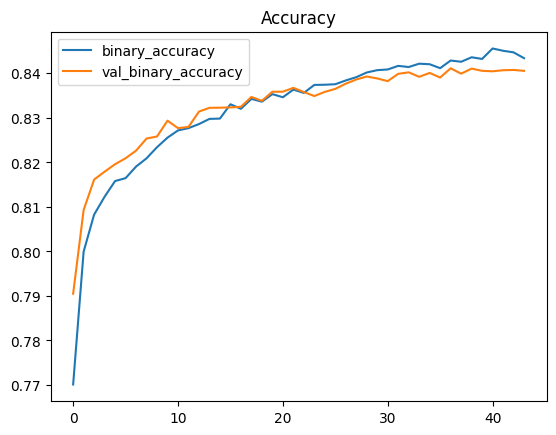

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [12]:
Y_new = model.predict(X_valid)

933/933 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
